# Hotel Reservation Prediction and Forecasting
## Foundations of Data Sciences Final Project

This notebook performs data cleaning, exploratory data analysis, and implements both an Artificial Neural Network (ANN) for classification and a SARIMAX model for forecasting future demand.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

### 1. Data Loading and Cleaning

In [2]:
# Load dataset
df = pd.read_csv("Hotel_reservations.csv")

# Convert arrival components to datetime
df['arrival_datetime'] = pd.to_datetime(
    df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-' + df['arrival_date'].astype(str),
    errors='coerce'
)

# Check for invalid dates (e.g., Feb 29 on non-leap years)
invalid_dates = df[df['arrival_datetime'].isna()]
print(f"Number of invalid dates found and dropped: {len(invalid_dates)}")

# Drop rows with null arrival_datetime
data = df.dropna(subset=['arrival_datetime']).copy()

# Display basic info
data.info()

Number of invalid dates found and dropped: 37
<class 'pandas.DataFrame'>
Index: 36238 entries, 0 to 36274
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Booking_ID                            36238 non-null  str           
 1   no_of_adults                          36238 non-null  int64         
 2   no_of_children                        36238 non-null  int64         
 3   no_of_weekend_nights                  36238 non-null  int64         
 4   no_of_week_nights                     36238 non-null  int64         
 5   type_of_meal_plan                     36238 non-null  str           
 6   required_car_parking_space            36238 non-null  int64         
 7   room_type_reserved                    36238 non-null  str           
 8   lead_time                             36238 non-null  int64         
 9   arrival_year                          3623

### 2. Exploratory Data Analysis (EDA)

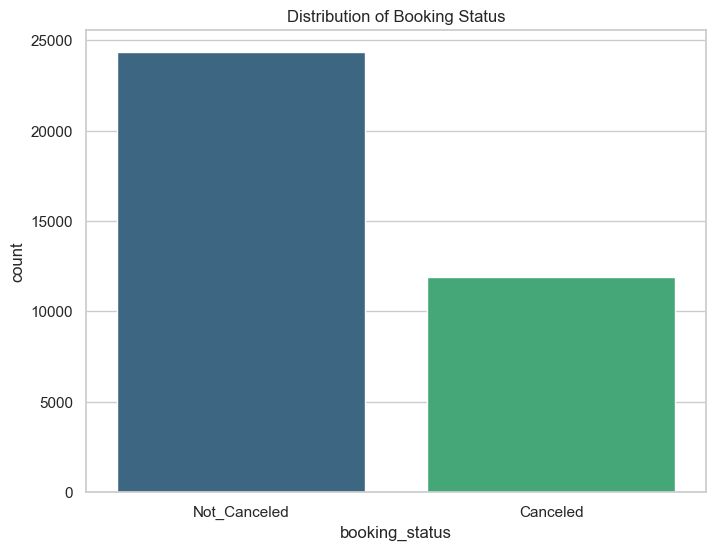

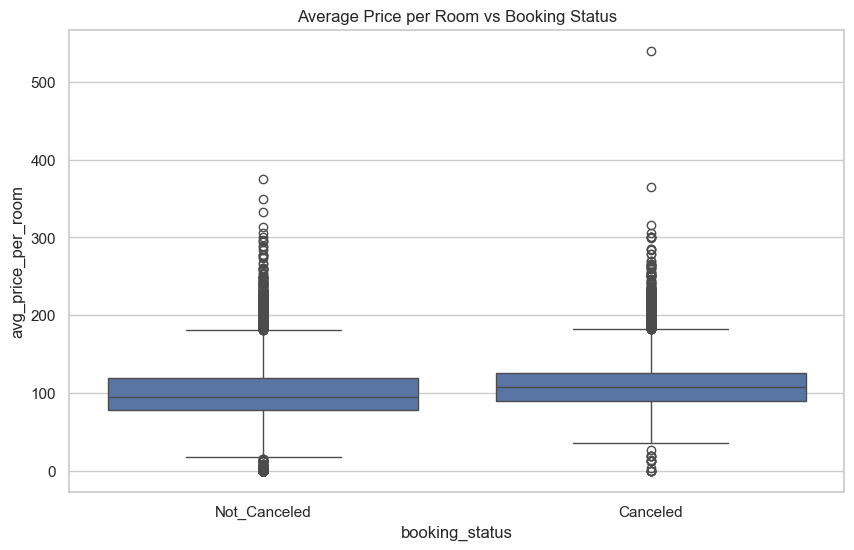

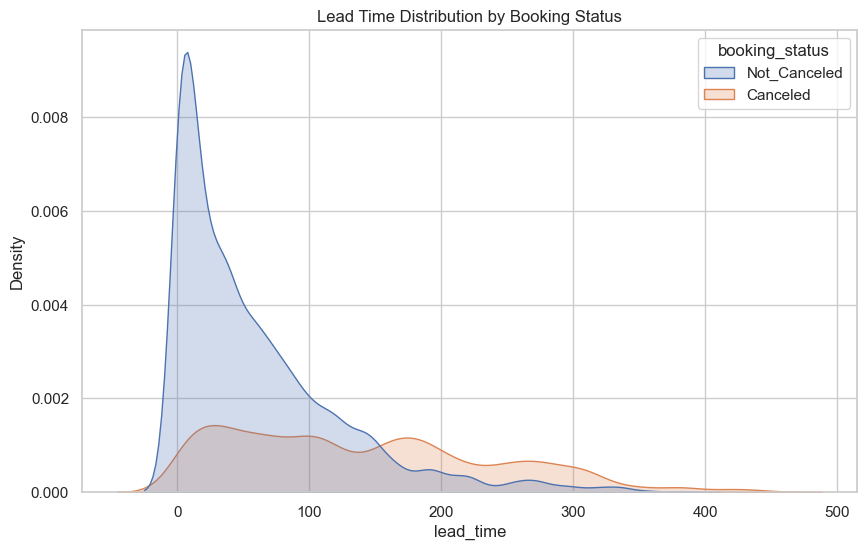

In [3]:
# Distribution of Booking Status
plt.figure(figsize=(8, 6))
sns.countplot(x='booking_status', data=data, palette='viridis')
plt.title('Distribution of Booking Status')
plt.show()

# Average Price per Room vs Booking Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='booking_status', y='avg_price_per_room', data=data)
plt.title('Average Price per Room vs Booking Status')
plt.show()

# Lead Time vs Booking Status
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='lead_time', hue='booking_status', fill=True)
plt.title('Lead Time Distribution by Booking Status')
plt.show()

### 3. Classification using ANN
We aim to predict whether a booking will be 'Canceled' or 'Not_Canceled'.

In [4]:
# Feature Selection
# Removing Booking_ID and arrival_datetime as they are identifiers/indices
X = data.drop(columns=['Booking_ID', 'booking_status', 'arrival_datetime'])
y = data['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

# Encoding categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

# Scaling numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build ANN Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Save the model
model.save('fds_hotel_model.h5')

Epoch 1/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7870 - loss: 0.4570 - val_accuracy: 0.8155 - val_loss: 0.4107
Epoch 2/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8147 - loss: 0.4132 - val_accuracy: 0.8255 - val_loss: 0.3975
Epoch 3/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8199 - loss: 0.4009 - val_accuracy: 0.8282 - val_loss: 0.3882
Epoch 4/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8248 - loss: 0.3909 - val_accuracy: 0.8282 - val_loss: 0.3844
Epoch 5/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8303 - loss: 0.3831 - val_accuracy: 0.8337 - val_loss: 0.3762
Epoch 6/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8311 - loss: 0.3798 - val_accuracy: 0.8368 - val_loss: 0.3746
Epoch 7/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8340 - loss: 0.3736 - val_accuracy: 0.8362 - val_loss: 0.3690
Epoch 8/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8337 - loss: 0.3732 - val_accuracy: 0.

Test Accuracy: 85.26%


### 4. Forecasting using SARIMAX
We will forecast the weekly demand for hotel bookings.

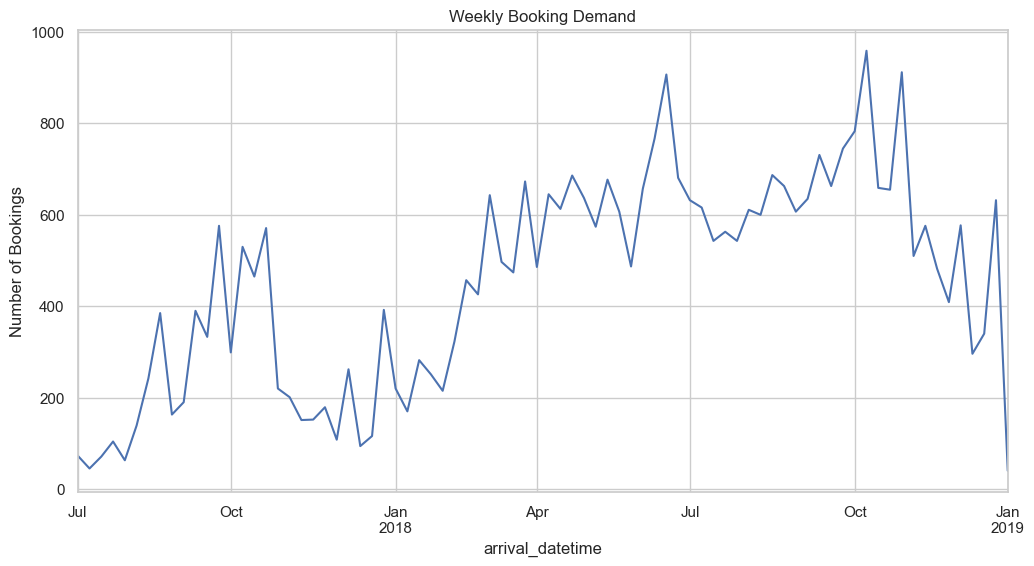

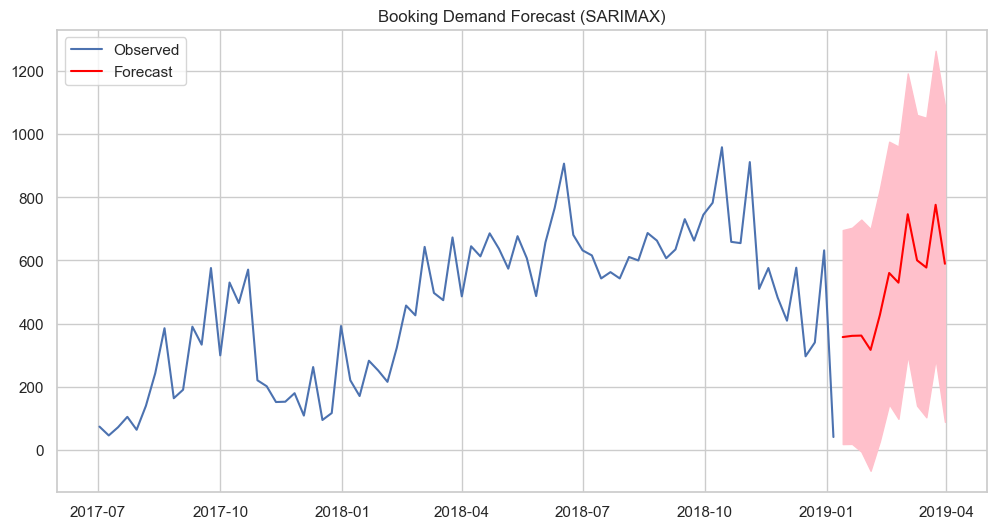

In [5]:
# Resample data for weekly frequency
weekly_data = data.resample('W', on='arrival_datetime').size()

plt.figure(figsize=(12, 6))
weekly_data.plot()
plt.title('Weekly Booking Demand')
plt.ylabel('Number of Bookings')
plt.show()

# Fit SARIMAX model
# Note: Parameters (p,d,q)(P,D,Q,s) should be tuned; using (1,1,1)(1,1,1,52) as a baseline
sarima_model = SARIMAX(weekly_data, order=(1,1,1), seasonal_order=(1,1,1,52), enforce_stationarity=False, enforce_invertibility=False)
results = sarima_model.fit()

# Forecast future demand (next 12 weeks)
forecast = results.get_forecast(steps=12)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index, weekly_data, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
plt.title('Booking Demand Forecast (SARIMAX)')
plt.legend()
plt.show()